In [229]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import os

In [230]:
### Ignore the warning message
import warnings
warnings.filterwarnings("ignore")

# Table of contents

0. Data preprocessing
    - [0.1 Data extracting](#0.1)
    - *[0.2 Calculating the reward](#0.2)
    - [0.3 Removing empty data](#0.3)
    - [0.4 Removing unimportant features](#0.4)
    - [0.5 Label Encoder](#0.5)
    - [0.6 Define the team of each player](#0.6)
    - *[0.7 Grouping](#0.7)
    - [0.8 Define y target](#0.8)
    - [0.9 Training and test data split](#0.9)
1. Classification model
    - [1.1 Logistic Regression model](#1.1)
    - [1.2 Decision Tree Classifier](#1.2)
    - [1.3 Ranom Forest Classifier](#1.3)
    - [1.4 SVC Classifier](#1.4)
    - [1.5 Linear SVC Classifier](#1.5)
    - [1.6 KNN Classifier](#1.6)
    - [1.7 Gradient Boosting Classifier](#1.7)
    - [1.8 Adaptive Boosting Classifier](#1.8)
2. Regression model - Score difference
    - [2.1 Linear Regression](#2.1)
    - [2.2 LASSO Regression](#2.2)
    - [2.3 SVR](#2.3)
    - [2.4 Random Forest Regressor](#2.4)
    - [2.5 KNN Regressor](#2.5)
    - [2.6 MLP Regressior (neural network)](#2.6)
    - [2.7 Decision Tree Regressior](#2.7)
    - [2.8 Gradient Boosting Regressor](#2.8)
3. Regression model - reward
    - [3.1 Linear Regression](#3.1)
    - [3.2 LASSO Regression](#3.2)
    - [3.3 SVR](#3.3)
    - [3.4 Random Forest Regressor](#3.4)
    - [3.5 KNN Regressor](#3.5)
    - [3.6 MLP Regressior (neural network)](#3.6)
    - [3.7 Decision Tree Regressior](#3.7)
    - [3.8 Gradient Boosting Regressor](#3.8)


# 0. Data preprocessing<a name = "0"></a>


## 0.1 Data extracting <a name = "0.1"></a>

In [231]:
# given the file directory
# folder_path mean the excel's file directory, needing revise to yourself location
folder_path = r'C:\Users\ppwan\!002. School related\002. UIUC ISE\006. CS 412- Introduction to Data Mining\Final project\Report'

# Extract csv name file only (CSV file in this directory means the raw data)
file_list = os.listdir(folder_path)
file_list = [file for file in file_list if file[-4:] == ".csv"]


# Read csv file based on the file name and merge all of them together
data = pd.read_csv(file_list[0])
for i in range(1, len(file_list)):
    data = pd.concat([data, pd.read_csv(file_list[i])], axis=0)

In [232]:
# check the information for the targeted data (watch out Dtype and Non-Null)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225909 entries, 0 to 2596
Data columns (total 92 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   pitch_type                       225803 non-null  object 
 1   game_date                        225909 non-null  object 
 2   release_speed                    225795 non-null  float64
 3   release_pos_x                    225801 non-null  float64
 4   release_pos_z                    225801 non-null  float64
 5   player_name                      225909 non-null  object 
 6   batter                           225909 non-null  int64  
 7   pitcher                          225909 non-null  int64  
 8   events                           58390 non-null   object 
 9   description                      225909 non-null  object 
 10  spin_dir                         0 non-null       float64
 11  spin_rate_deprecated             0 non-null       float64
 12  brea

1. At this moment, the Dtype of "pitcher" and "batter" are float64, we need to transdfer it to str
2. Removing empty data by deleting the complete rows
3. Check "game_date" column, now the Dtype is object (str)

## 0.2 Calculating the reward <a name = "0.2"></a>

In [233]:
# Read the reward table. I summarized it at excel
reward_list = pd.read_csv("Auxiliary file\event.csv")

# Merge data with the reward table
data = pd.merge(data, reward_list, on=["events", "description"], how='left')


del reward_list


## 0.3 Removing empty data<a name = "0.3"></a>

In [234]:
# Observe the number in the Non-Null Count colunmn from data.info(), defining features we can handle 
remove_null_list = ["pitcher", "batter", "effective_speed", "release_spin_rate", "release_extension", "release_speed", "pfx_x"]

# Removing empty data
for lst in remove_null_list:
    data = data[data[lst].notnull()]
    
# Transform Flot64 feature to STR by Float--> int --> str
data['pitcher'] = data['pitcher'].astype(int).astype(str)
data['batter'] = data['batter'].astype(int).astype(str)

# Transform the date column to datetime from object str
data['game_date'] = pd.to_datetime(data['game_date'])


# Reset the index of the merged data (essential to do for the following data preprocessing)
data = data.reset_index()
data.drop("index", axis=1, inplace=True)

In [235]:
# check the information for the targeted data (watch out Dtype and Non-Null)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225456 entries, 0 to 225455
Data columns (total 93 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   pitch_type                       225456 non-null  object        
 1   game_date                        225456 non-null  datetime64[ns]
 2   release_speed                    225456 non-null  float64       
 3   release_pos_x                    225456 non-null  float64       
 4   release_pos_z                    225456 non-null  float64       
 5   player_name                      225456 non-null  object        
 6   batter                           225456 non-null  object        
 7   pitcher                          225456 non-null  object        
 8   events                           58260 non-null   object        
 9   description                      225456 non-null  object        
 10  spin_dir                         0 non-null 

1. At this moment, the Dtype of "pitcher" and "batter" are str.
2. Most of the Non-Null Count is the same
3. The Dtype of "game_date" becomes datetime64

In [236]:
data.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,reward
0,SI,2022-10-02,87.1,-0.82,6.20,"Wainwright, Adam",669261,425794,single,hit_into_play,...,6,5,6,5,Strategic,Standard,199.0,-0.132,0.921,-1
1,CU,2022-10-02,74.1,-0.86,6.44,"Wainwright, Adam",669261,425794,NaN,foul,...,5,5,5,5,Strategic,Standard,41.0,0.000,0.000,0
2,CU,2022-10-02,74.3,-0.94,6.38,"Wainwright, Adam",669261,425794,NaN,blocked_ball,...,5,5,5,5,Strategic,Standard,35.0,0.000,0.038,0
3,SI,2022-10-02,86.7,-1.02,6.26,"Wainwright, Adam",669261,425794,NaN,foul,...,5,5,5,5,Infield shift,Standard,200.0,0.000,-0.099,0
4,FC,2022-10-02,82.1,-1.08,6.37,"Wainwright, Adam",669261,425794,NaN,ball,...,5,5,5,5,Infield shift,Standard,92.0,0.000,0.031,-1



## 0.4 Removing unimportant features<a name = "0.4"></a>

In [237]:
important_features = ['pitch_type', 'game_date', "pitcher", "home_team", "away_team", 
                      'post_home_score', 'post_away_score', 'player_name', 'release_speed', 
                      'release_pos_x', 'release_pos_z', 'zone','pfx_x', 'pfx_z', 'plate_x', 
                      'plate_z','vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'effective_speed', 
                      'release_spin_rate', 'release_extension', 'release_pos_y', 'reward']

# keep the important features only
df = data[important_features]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225456 entries, 0 to 225455
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   pitch_type         225456 non-null  object        
 1   game_date          225456 non-null  datetime64[ns]
 2   pitcher            225456 non-null  object        
 3   home_team          225456 non-null  object        
 4   away_team          225456 non-null  object        
 5   post_home_score    225456 non-null  int64         
 6   post_away_score    225456 non-null  int64         
 7   player_name        225456 non-null  object        
 8   release_speed      225456 non-null  float64       
 9   release_pos_x      225456 non-null  float64       
 10  release_pos_z      225456 non-null  float64       
 11  zone               225456 non-null  float64       
 12  pfx_x              225456 non-null  float64       
 13  pfx_z              225456 non-null  float64 

1. Only 25 features left.


## 0.5 Label Encoder<a name = "0.5"></a>

Since "pitch_type" column is quite important for our data analysis(from experience), our goal at this section is aim label "pitch_type" and transform it to multiple categorical features

In [238]:
# check data first 
pitch = data['pitch_type'].value_counts()

pitch_type_table = pd.DataFrame(pitch).reset_index()
pitch_type_table = pitch_type_table.rename(columns={'pitch_type': '# of rows'})
pitch_type_table

,index,# of rows
0,FF,71496
1,SI,35392
2,SL,33980
3,CH,27319
4,CU,20410
5,FC,18173
6,KC,7405
7,ST,5831
8,FS,4504
9,SV,873


In [239]:
# check how many unique pitch_type in this data set
# the same as list(df['pitch_type'].drop_duplicates())
unique_pitch_types = df['pitch_type'].unique()


# Create binary columns for each pitch type
# Given each new-created columns a 0 or 1 value
for pitch_type in unique_pitch_types:
    column_name = 'pitch_' +str(pitch_type)
    df[column_name] = (df['pitch_type'] == pitch_type).astype(int)
    
# Drop the original 'pitch_type' column
df.drop('pitch_type', axis=1, inplace=True)

In [240]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225456 entries, 0 to 225455
Data columns (total 38 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   game_date          225456 non-null  datetime64[ns]
 1   pitcher            225456 non-null  object        
 2   home_team          225456 non-null  object        
 3   away_team          225456 non-null  object        
 4   post_home_score    225456 non-null  int64         
 5   post_away_score    225456 non-null  int64         
 6   player_name        225456 non-null  object        
 7   release_speed      225456 non-null  float64       
 8   release_pos_x      225456 non-null  float64       
 9   release_pos_z      225456 non-null  float64       
 10  zone               225456 non-null  float64       
 11  pfx_x              225456 non-null  float64       
 12  pfx_z              225456 non-null  float64       
 13  plate_x            225456 non-null  float64 

In [256]:
[i for i in range(26,38)]

[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]

In [265]:
pitch_type_column_name = pd.DataFrame(df.columns[26:], [i for i in range(26,38)], columns = ["new added colum names"]).reset_index()
pitch_type_column_name 

,index,new added colum names
0,26,pitch_SI
1,27,pitch_CU
2,28,pitch_FC
3,29,pitch_FF
4,30,pitch_CH
5,31,pitch_CS
6,32,pitch_SL
7,33,pitch_ST
8,34,pitch_FS
9,35,pitch_KC



## 0.6 Define the team of each player<a name = "0.6"></a>

In [118]:
# Define a two dictionary to storage information. One (home) to storage raw information, 
# another (home_final) pass out the max count of the team in its dixtionary
home = {}


# storage the pitcher name into the two given dictionary
for pitcher in data["pitcher"].drop_duplicates():
    home[pitcher] = {}
home_final = home.copy()
    

# Count the "home_team" and "away_team" count by each pitcher
for i in range(data.shape[0]):
    home[data["pitcher"][i]][data["home_team"][i]] = home[data["pitcher"][i]].setdefault(data["home_team"][i], 0) + 1
    home[data["pitcher"][i]][data["away_team"][i]] = home[data["pitcher"][i]].setdefault(data["away_team"][i], 0) + 1

# the maximum count of corresponding team is the team of the player
for player in home_final:
    home_final[player] = max(home[player].items(), key= lambda x: x[-1])[0]
    
del home

In [119]:
# the result will be
home_final

{'425794': 'STL',
 '425844': 'KC',
 '434378': 'HOU',
 '446372': 'TB',
 '448179': 'BOS',
 '450203': 'ATL',
 '453286': 'NYM',
 '456501': 'CWS',
 '471911': 'NYM',
 '477132': 'LAD',
 '502043': 'PHI',
 '502171': 'SF',
 '502179': 'WSH',
 '506433': 'SD',
 '527048': 'TEX',
 '542881': 'LAD',
 '543037': 'NYY',
 '543475': 'BAL',
 '554430': 'PHI',
 '571578': 'WSH',
 '571945': 'STL',
 '579328': 'TOR',
 '592332': 'TOR',
 '592351': 'TEX',
 '592662': 'SEA',
 '592767': 'CHC',
 '592791': 'NYY',
 '592836': 'NYM',
 '593423': 'OAK',
 '594835': 'SEA',
 '601713': 'BOS',
 '605135': 'NYM',
 '605164': 'MIN',
 '605182': 'SD',
 '605288': 'MIL',
 '605400': 'PHI',
 '605483': 'SD',
 '605540': 'MIL',
 '607074': 'SF',
 '607200': 'WSH',
 '607536': 'COL',
 '608331': 'ATL',
 '608337': 'CWS',
 '608344': 'OAK',
 '608379': 'BOS',
 '608566': 'COL',
 '615698': 'CLE',
 '621076': 'OAK',
 '622072': 'SF',
 '622491': 'CIN',
 '623167': 'SEA',
 '624133': 'PHI',
 '628711': 'LAD',
 '640455': 'SD',
 '641482': 'NYY',
 '641540': 'TEX',
 


## 0.7 Grouping<a name = "0.7"></a>

Three grouping tables:

1. One is to get the average mean of each feature grouping by ['game_date', "pitcher"]. For example, spin_rate, release_speed, .... etc.

2. One is to get the maximum values of each feature grouping by ['game_date', "pitcher"]. For example, post_away_score, post_home_score.

3. One is to get the sum of each feature grouping by ['game_date', "pitcher"]. For example, reward

Besides, we should merge the features include teams("home_team", "away_team") separately (because group can not include features which are not value

In [120]:
new_column = [feature for feature in df.columns if feature not in ["reward",'post_away_score', 'post_home_score']]
result = df[new_column].groupby(['game_date', "pitcher"]).mean().reset_index().sort_values(['game_date', "pitcher"])
result

,game_date,pitcher,release_speed,release_pos_x,release_pos_z,zone,pfx_x,pfx_z,plate_x,plate_z,...,pitch_FC,pitch_FF,pitch_CH,pitch_CS,pitch_SL,pitch_ST,pitch_FS,pitch_KC,pitch_PO,pitch_SV
0,2022-04-07,425794,82.396296,-1.156667,6.359136,8.790123,-0.064074,0.366049,0.062963,2.374938,...,0.185185,0.074074,0.111111,0.024691,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,2022-04-07,425844,84.888095,-1.186429,6.215476,9.392857,-0.084524,0.598810,-0.110714,2.143571,...,0.285714,0.261905,0.178571,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,2022-04-07,506433,90.113043,-1.784783,5.627500,9.543478,0.098152,0.693696,-0.010326,2.085543,...,0.000000,0.500000,0.000000,0.000000,0.184783,0.173913,0.108696,0.010870,0.0,0.0
3,2022-04-07,571578,87.013158,2.206842,6.367237,9.881579,0.424605,0.805921,-0.125263,2.182763,...,0.000000,0.394737,0.065789,0.000000,0.315789,0.000000,0.000000,0.000000,0.0,0.0
4,2022-04-07,608331,87.591667,1.307857,6.072976,8.333333,-0.124167,0.249524,-0.332619,2.638452,...,0.000000,0.452381,0.059524,0.000000,0.166667,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2572,2022-10-05,657248,87.085714,-1.711429,6.056623,9.051948,0.129221,0.361948,-0.104286,2.442208,...,0.000000,0.272727,0.000000,0.000000,0.000000,0.311688,0.000000,0.142857,0.0,0.0
2573,2022-10-05,660271,87.901449,-2.346522,5.865507,8.434783,0.241014,0.307971,0.010145,2.193478,...,0.130435,0.057971,0.000000,0.000000,0.072464,0.420290,0.028986,0.000000,0.0,0.0
2574,2022-10-05,664285,86.470455,0.970568,6.223182,9.340909,0.293409,-0.230455,-0.386591,1.754205,...,0.125000,0.000000,0.034091,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2575,2022-10-05,669203,91.215000,-0.515750,6.044250,10.950000,0.346500,0.451000,0.570000,1.686500,...,0.600000,0.000000,0.125000,0.000000,0.050000,0.000000,0.000000,0.000000,0.0,0.0


In [121]:
# From 3, get the average of the defined feature by grouping. 
# Should reset the index because we need to construct a table 
# Should order the table by defined features because we will merge two table later.
# 此區域需要用mean的原因是我們關注每場比賽的結果(所以需要把每個features的data根據不同天不同投球的結果做mean平均)
new_column = [feature for feature in df.columns if feature not in ["reward",'post_away_score', 'post_home_score']]
result = df[new_column].groupby(['game_date', "pitcher"]).mean().reset_index().sort_values(['game_date', "pitcher"])

# From 2, get the maximium of the defined features by grouping. 
# Should reset the index because we need to construct a table 
# Should order the table by defined features because we will merge two table later.
# 用max()的原因是我們要看一場比賽的最後比數是多少(這邊feature的值是每場比賽會累計,最後再來看主客場得失分差來決定勝負)
df_final_scores_max = df[['game_date', "pitcher", 'post_away_score', 'post_home_score']].groupby(['game_date', "pitcher"]).\
                    max().reset_index().sort_values(['game_date', "pitcher"])

df_final_scores_min = df[['game_date', "pitcher", 'post_away_score', 'post_home_score']].groupby(['game_date', "pitcher"]).\
                    min().reset_index().sort_values(['game_date', "pitcher"])


# Merge final score difference
df_difference = df_final_scores_max[['post_away_score', 'post_home_score']]-df_final_scores_min[['post_away_score', 'post_home_score']]
result[['post_away_score', 'post_home_score']] = df_difference[['post_away_score', 'post_home_score']]


# From 3, get the sum of the defined feature by grouping. 
# Should reset the index because we need to construct a table 
# Should order the table by defined features because we will merge two table later.
# 用sum()的原因是我們要看每場比賽這位投手所投出的reward 總值是多少,越高代表這投手的quality越好, 越容易贏
df_reward = df[['game_date', "pitcher", 'reward']].groupby(['game_date', "pitcher"]).\
                    sum().reset_index().sort_values(['game_date', "pitcher"])


# Put "home_team", "away_team" back to the merged table
df_check = df[["game_date", "pitcher", "home_team", "away_team"]].drop_duplicates().sort_values(['game_date', "pitcher"])

# Merge all above two tables and "home_team", "away_team", "reward"
result = pd.merge(result, df_check, on=['game_date', "pitcher"])
result = pd.merge(result, df_reward, on=['game_date', "pitcher"])

In [122]:
result.head()

,game_date,pitcher,release_speed,release_pos_x,release_pos_z,zone,pfx_x,pfx_z,plate_x,plate_z,...,pitch_ST,pitch_FS,pitch_KC,pitch_PO,pitch_SV,post_away_score,post_home_score,home_team,away_team,reward
0,2022-04-07,425794,82.396296,-1.156667,6.359136,8.790123,-0.064074,0.366049,0.062963,2.374938,...,0.000000,0.000000,0.00000,0.0,0.0,0,4,STL,PIT,-16
1,2022-04-07,425844,84.888095,-1.186429,6.215476,9.392857,-0.084524,0.598810,-0.110714,2.143571,...,0.000000,0.000000,0.00000,0.0,0.0,1,1,KC,CLE,-13
2,2022-04-07,506433,90.113043,-1.784783,5.627500,9.543478,0.098152,0.693696,-0.010326,2.085543,...,0.173913,0.108696,0.01087,0.0,0.0,2,0,AZ,SD,-16
3,2022-04-07,571578,87.013158,2.206842,6.367237,9.881579,0.424605,0.805921,-0.125263,2.182763,...,0.000000,0.000000,0.00000,0.0,0.0,1,0,WSH,NYM,-18
4,2022-04-07,608331,87.591667,1.307857,6.072976,8.333333,-0.124167,0.249524,-0.332619,2.638452,...,0.000000,0.000000,0.00000,0.0,0.0,3,1,ATL,CIN,-15



## 0.8 Define y target<a name = "0.8"></a>

* Calculate the score difference in one game (we should define if "post_home_score" - "post_away_score" or "post_away_score" - "post_home_score")
* Based on the result, we will define it to +1 (win), 0 (draw), -1 (lose).

In [123]:
# Calculate the score difference in one game
temp = []
win_or_lose = []
for i in range(result.shape[0]):
    # based on the dictionary we get from home_final to define the if this player is at the home team or at the away team.
    # if the player is located in away team, the score difference should be : "post_away_score" - "post_home_score"
    # others will be "post_home_score" - "post_away_score"
    if result["home_team"][i] == home_final[result["pitcher"][i]]:
        temp.append(result["post_home_score"][i] - result["post_away_score"][i])
    else:
        temp.append(result["post_away_score"][i] - result["post_home_score"][i])
        
# Give it +1 (win), 0 (draw), -1 (lose) based on the result we get previously      
# for num in temp:
#     if num>0:
#         win_or_lose.append(1)
#     elif num <0:
#         win_or_lose.append(-1)
#     else:
#         win_or_lose.append(0)
        
for num in temp:
    if num>=0:
        win_or_lose.append(1)
    else:
        win_or_lose.append(0)
        
result['diff_score'] = temp
result["win"] = win_or_lose
del temp, win_or_lose

drop_2 = ['post_home_score','post_away_score', "home_team", "away_team"]
result = result.drop(drop_2,axis=1)

In [124]:
result.head()

,game_date,pitcher,release_speed,release_pos_x,release_pos_z,zone,pfx_x,pfx_z,plate_x,plate_z,...,pitch_CS,pitch_SL,pitch_ST,pitch_FS,pitch_KC,pitch_PO,pitch_SV,reward,diff_score,win
0,2022-04-07,425794,82.396296,-1.156667,6.359136,8.790123,-0.064074,0.366049,0.062963,2.374938,...,0.024691,0.000000,0.000000,0.000000,0.00000,0.0,0.0,-16,4,1
1,2022-04-07,425844,84.888095,-1.186429,6.215476,9.392857,-0.084524,0.598810,-0.110714,2.143571,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,-13,0,1
2,2022-04-07,506433,90.113043,-1.784783,5.627500,9.543478,0.098152,0.693696,-0.010326,2.085543,...,0.000000,0.184783,0.173913,0.108696,0.01087,0.0,0.0,-16,2,1
3,2022-04-07,571578,87.013158,2.206842,6.367237,9.881579,0.424605,0.805921,-0.125263,2.182763,...,0.000000,0.315789,0.000000,0.000000,0.00000,0.0,0.0,-18,-1,0
4,2022-04-07,608331,87.591667,1.307857,6.072976,8.333333,-0.124167,0.249524,-0.332619,2.638452,...,0.000000,0.166667,0.000000,0.000000,0.00000,0.0,0.0,-15,-2,0


In [125]:
from sklearn.model_selection import train_test_split


## 0.9 Training and test data split<a name = "0.9"></a>

In [126]:
# Get rid of 'game_date', 'pitcher' from the training and the test dataset 
# "win", "reward" are target data, so we don't need it in the training dataset.
all_columns = [col for col in result.columns if col not in ['game_date', 'pitcher', 'diff_score', "win", "reward"]]


X_train, X_test, y_train, y_test = train_test_split(result, result[["diff_score", "win", "reward"]], random_state=5, test_size=0.1)

# Training set
X_train_1 = X_train[all_columns]
y_train_1 = y_train["diff_score"]
y_train_2 = y_train['win']
y_train_3 = y_train['reward']

# Test set
X_test_1 = X_test[all_columns]
y_test_1 = y_test["diff_score"]
y_test_2 = y_test['win']
y_test_3 = y_test['reward']

In [127]:
# test_1 代表的是分差 (score difference)
# test_2 代表的是贏會輸 --> 只用在calssification, 這邊用不到
# test_2 代表的是reward


# 1. Classification model

In [128]:
from sklearn.model_selection import GridSearchCV

In [129]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score


## 1.1 Logistic Regression model<a name = "1.1"></a>

In [130]:
# logistic_regression = LogisticRegression()

# param_grid_logistic = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'penalty': ['l1', 'l2'],
#     'solver': ['liblinear', 'lbfgs']
# }


# grid_search_logistic = GridSearchCV(estimator=logistic_regression, param_grid=param_grid_logistic, scoring='accuracy', cv=5)
# grid_search_logistic.fit(X_train_1, y_train_2)
# best_logistic_regression = grid_search_logistic.best_estimator_
# y_pred_logistic = best_logistic_regression.predict((X_test_1))

# logistic_accuracy = accuracy_score(y_test_2, y_pred_logistic)
# print("Best Parameters: ", grid_search_logistic.best_params_)
# print("Best Accuracy: ", logistic_accuracy)


## 1.2 Decision Tree Classifier<a name = "1.2"></a>

In [131]:
# dtc_classifier = DecisionTreeClassifier()

# param_grid_dtc = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }


# grid_search_dtc = GridSearchCV(estimator=dtc_classifier, param_grid=param_grid_dtc, scoring='accuracy', cv=5)
# grid_search_dtc.fit(X_train_1, y_train_2)
# best_dtc = grid_search_dtc.best_estimator_
# y_pred_dtc = best_dtc.predict(X_test_1)

# dtc_accuracy = accuracy_score(y_test_2, y_pred_dtc)
# print("Best Parameters: ", grid_search_dtc.best_params_)
# print("Best Accuracy: ", dtc_accuracy)


## 1.3 Ranom Forest Classifier<a name = "1.3"></a>

In [132]:
# rfc_classifier = RandomForestClassifier()

# param_grid_rfc = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }


# grid_search_rfc = GridSearchCV(estimator=rfc_classifier, param_grid=param_grid_rfc, scoring='accuracy', cv=5)
# grid_search_rfc.fit(X_train_1, y_train_2)
# best_rfc = grid_search_rfc.best_estimator_
# y_pred_rfc = best_rfc.predict(X_test_1)

# rfc_accuracy = accuracy_score(y_test_2, y_pred_rfc)
# print("Best Parameters: ", grid_search_rfc.best_params_)
# print("Best Accuracy: ", rfc_accuracy)


## 1.4 SVC Classifier<a name = "1.4"></a>

In [133]:
# svc_classifier = SVC()


# param_grid_svc = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf', 'poly'],
#     'gamma': ['scale', 'auto'],
# }


# grid_search_svc = GridSearchCV(estimator=svc_classifier, param_grid=param_grid_svc, scoring='accuracy', cv=5)
# grid_search_svc.fit(X_train_1, y_train_2)
# best_svc = grid_search_svc.best_estimator_
# y_pred_svc = best_svc.predict(X_test)

# svc_accuracy = accuracy_score(y_test_2, y_pred_svc)
# print("Best Parameters: ", grid_search_svc.best_params_)
# print("Best Accuracy: ", svc_accuracy)


## 1.5 Linear SVC Classifier<a name = "1.5"></a>

In [134]:
# linear_svc_classifier = LinearSVC()


# param_grid = {
#     'C': [0.1, 1, 10],
# }


# grid_search_linear_svc = GridSearchCV(estimator=linear_svc_classifier, param_grid=param_grid_linear_svc, scoring='accuracy', cv=5)
# grid_search_linear_svc.fit(X_train_1, y_train_2)
# best_linear_svc = grid_search_linear_svc.best_estimator_
# y_pred_linear_svc = best_linear_svc.predict(X_test_1)


# linear_svc_accuracy = accuracy_score(y_test_2, y_pred_linear_svc)
# print("Best Parameters: ", grid_search_linear_svc.best_params_)
# print("Best Accuracy: ", linear_svc_accuracy)


## 1.6 KNN Classifier<a name = "1.6"></a>

In [135]:
# knn_classifier = KNeighborsClassifier()


# param_grid_knn = {
#     'n_neighbors': [3, 5, 7],
#     'weights': ['uniform', 'distance'],
#     'p': [1, 2]
# }


# grid_search_knn = GridSearchCV(estimator=knn_classifier, param_grid=param_grid_knn, scoring='accuracy', cv=5)
# grid_search_knn.fit(X_train_1, y_train_2)
# best_knn = grid_search_knn.best_estimator_
# y_pred_knn = best_knn.predict(X_test_1)
# knn_accuracy = accuracy_score(y_test_2, y_pred_knn)
# print("Best Parameters: ", grid_search_knn.best_params_)
# print("Best Accuracy: ", knn_accuracy)


## 1.7 Gradient Boosting Classifier<a name = "1.7"></a>

In [136]:
# gbc_classifier = GradientBoostingClassifier()

# param_grid_gbc = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 4, 5],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'subsample': [0.8, 1.0],
# }


# grid_search_gbc = GridSearchCV(estimator=gbc_classifier, param_grid=param_grid_gbc, scoring='accuracy', cv=5)
# grid_search_gbc.fit(X_train_1, y_train_2)
# best_gbc = grid_search_gbc.best_estimator_
# y_pred_gbc = best_gbc.predict(X_test_1)

# gbc_accuracy = accuracy_score(y_test_2, y_pred_gbc)
# print("Best Parameters: ", grid_search_gbc.best_params_)
# print("Best Accuracy: ", gbc_accuracy)

## 1.8 Adaptive Boosting Classifier<a name = "1.8"></a>

In [137]:
# adaboost_classifier = AdaBoostClassifier()


# param_grid_adaboost = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2],
# }


# grid_search_adaboost = GridSearchCV(estimator=adaboost_classifier, param_grid=param_grid_adaboost, scoring='accuracy', cv=5)
# grid_search_adaboost.fit(X_train_1, y_train_2)
# best_adaboost = grid_search_adaboost.best_estimator_
# y_pred_adaboost = best_adaboost.predict(X_test_1)


# adaboost_accuracy = accuracy_score(y_test_2, y_pred_adaboost)
# print("Best Parameters: ", grid_search_adaboost.best_params_)
# print("Best Accuracy: ", adaboost_accuracy)


# 2. Regression model

In [138]:
# Using reward

In [139]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

## 2.1 Linear Regression<a name = "2.1"></a>

In [140]:
LR = LinearRegression()
LR.fit(X_train_1, y_train_3)
ypred = LR.predict(X_test_1)
LR_mse = mean_squared_error(y_test_3, ypred)
LR_acc = LR.score(X_test_1,y_test_3)
print(f"Mean Squared Error: {LR_mse}")
print(f"Accuracy: {LR_acc}")

Mean Squared Error: 54.845142387615965
Accuracy: 0.19638464361893848


In [141]:
print(y_test_3.mean()) # reward
print(y_test_1.mean()) # score difference

-15.007751937984496
-0.10852713178294573


## 2.2 LASSO Regression<a name = "2.2"></a>

In [142]:
lasso_regressor = Lasso()

param_grid_LASSO = {
    'alpha': [0.01, 0.1, 1.0, 10.0],
    'max_iter': [100, 500, 1000],
}

grid_search_LASSO = GridSearchCV(estimator=lasso_regressor, param_grid=param_grid_LASSO, scoring='neg_mean_squared_error', cv=5)
grid_search_LASSO.fit(X_train_1, y_train_3)
best_lasso = grid_search_LASSO.best_estimator_
y_pred_LASSO = best_lasso.predict(X_test_1)

LASSO_mse = mean_squared_error(y_test_3, y_pred_LASSO)
print("Best Parameters: ", grid_search_LASSO.best_params_)
print("Best MSE: ", LASSO_mse)

Best Parameters:  {'alpha': 0.01, 'max_iter': 500}
Best MSE:  56.320242588021344


## 2.3 SVR<a name = "2.3"></a>

In [143]:
svr = SVR()
param_grid_SVR = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
}

grid_search_SVR = GridSearchCV(estimator=svr, param_grid=param_grid_SVR, scoring='neg_mean_squared_error', cv=5)
grid_search_SVR.fit(X_train_1, y_train_3)
best_svr = grid_search_SVR.best_estimator_
y_pred_svr = best_svr.predict(X_test_1)


svr_mse = mean_squared_error(y_test_3, y_pred_svr)
print("Best Parameters: ", grid_search_SVR.best_params_)
print("Best MSE: ", svr_mse)

Best Parameters:  {'C': 1, 'epsilon': 1, 'kernel': 'linear'}
Best MSE:  58.538512392956804


## 2.4 Random Forest Regressor<a name = "2.4"></a>

In [144]:
rf_regressor = RandomForestRegressor()


param_grid_rf = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


grid_search_rf = GridSearchCV(estimator=rf_regressor, param_grid=param_grid_rf, scoring='neg_mean_squared_error', cv=5)
grid_search_rf.fit(X_train_1, y_train_3)
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_1)
rf_mse = mean_squared_error(y_test_3, y_pred_rf)
print("Best Parameters: ", grid_search_rf.best_params_)
print("Best MSE: ", rf_mse)

Best Parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best MSE:  60.17578875968993


## 2.5 KNN Regressor<a name = "2.5"></a>

In [145]:
knnr_regressor = KNeighborsRegressor()

param_grid_knnr = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_search_knnr = GridSearchCV(estimator=knnr_regressor, param_grid=param_grid_knnr, scoring='neg_mean_squared_error', cv=5)
grid_search_knnr.fit(X_train_1, y_train_3)
best_knnr = grid_search_knnr.best_estimator_
y_pred_knnr = best_knnr.predict(X_test_1)


knnr_mse = mean_squared_error(y_test_3, y_pred_knnr)
print("Best Parameters: ", grid_search_knnr.best_params_)
print("Best MSE: ", knnr_mse)

Best Parameters:  {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best MSE:  73.98214163847629


## 2.6 MLP Regressior (neural network)<a name = "2.6"></a>

In [146]:
mlp_regressor = MLPRegressor()

param_grid_MLP = {
    'hidden_layer_sizes': [(50, ), (100, ), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

grid_search_MLP = GridSearchCV(estimator=mlp_regressor, param_grid=param_grid_MLP, scoring='neg_mean_squared_error', cv=5)
grid_search_MLP.fit(X_train_1, y_train_3)
best_mlp = grid_search_MLP.best_estimator_
y_pred_MLP = best_mlp.predict(X_test_1)

mlp_mse = mean_squared_error(y_test_3, y_pred_MLP)
print("Best Parameters: ", grid_search_MLP.best_params_)
print("Best MSE: ", mlp_mse)

Best Parameters:  {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}
Best MSE:  67.63226892498231


## 2.7 Decision Tree Regressior<a name = "2.7"></a>

In [147]:
dt_regressor = DecisionTreeRegressor()

# Define the hyperparameter grid
param_grid_DT = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_DT = GridSearchCV(estimator=dt_regressor, param_grid=param_grid_DT, scoring='neg_mean_squared_error', cv=5)
grid_search_DT.fit(X_train_1, y_train_3)
best_dt = grid_search_DT.best_estimator_
y_pred_DT = best_dt.predict(X_test_1)


dt_mse = mean_squared_error(y_test_3, y_pred_DT)
print("Best Parameters: ", grid_search_DT.best_params_)
print("Best MSE: ", dt_mse)

Best Parameters:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best MSE:  87.44926380702225


## 2.8 Gradient Boosting Regressor<a name = "2.8"></a>

In [148]:
gbr_regressor = GradientBoostingRegressor()

param_grid_gbr = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0],
}


grid_search_gbr = GridSearchCV(estimator=gbr_regressor, param_grid=param_grid_gbr, scoring='neg_mean_squared_error', cv=5)
grid_search_gbr.fit(X_train_1, y_train_3)
best_gbr = grid_search_gbr.best_estimator_
y_pred_gbr = best_gbr.predict(X_test_1)

gbr_mse = mean_squared_error(y_test_3, y_pred_gbr)
print("Best Parameters: ", grid_search_gbr.best_params_)
print("Best MSE: ", gbr_mse)

Best Parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.8}
Best MSE:  57.29992724084062


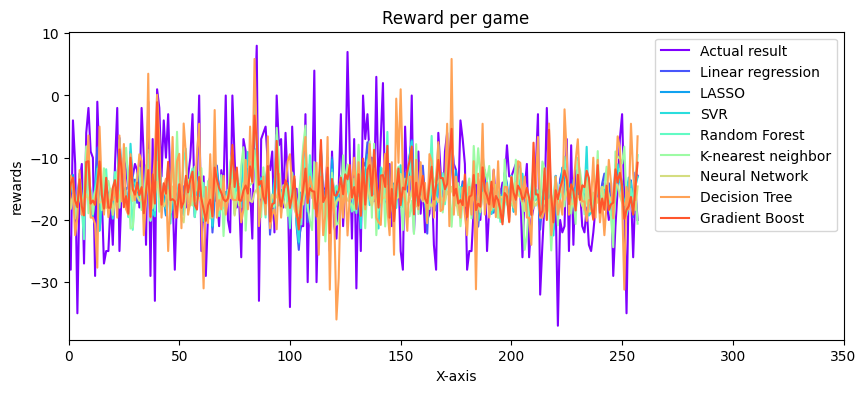

In [149]:
plt.figure(figsize=(10, 4))
y_result = [y_test_3, ypred, y_pred_LASSO, y_pred_svr, y_pred_rf, y_pred_knnr, y_pred_MLP, y_pred_DT, y_pred_gbr]
mark = ["Actual result", "Linear regression", "LASSO", "SVR", "Random Forest", "K-nearest neighbor", 
        "Neural Network", "Decision Tree", "Gradient Boost"]
for i in range(len(y_result)):
    color = plt.cm.rainbow(i / len(y_result))  
    plt.plot(range(len(y_result[i])), y_result[i],  label=mark[i], color=color)
    

plt.xlim(0,350)    
plt.xlabel('X-axis')
plt.ylabel('rewards')
plt.title('Reward per game')
plt.legend(loc='upper right')
plt.show()

In [150]:
MSE_result = [LR_mse, LASSO_mse, svr_mse, rf_mse, knnr_mse, mlp_mse, dt_mse, gbr_mse]
column_names = mark[1:]
table_df = pd.DataFrame(MSE_result, columns = ["reward_MSE"], index = column_names)

min_result = table_df["reward_MSE"].min()

def text_num_color(val):
    if val == min_result:
        return 'color: red'  

table_df = table_df.style.applymap(text_num_color, subset=["reward_MSE"])
table_df

,reward_MSE
Linear regression,54.845142
LASSO,56.320243
SVR,58.538512
Random Forest,60.175789
K-nearest neighbor,73.982142
Neural Network,67.632269
Decision Tree,87.449264
Gradient Boost,57.299927


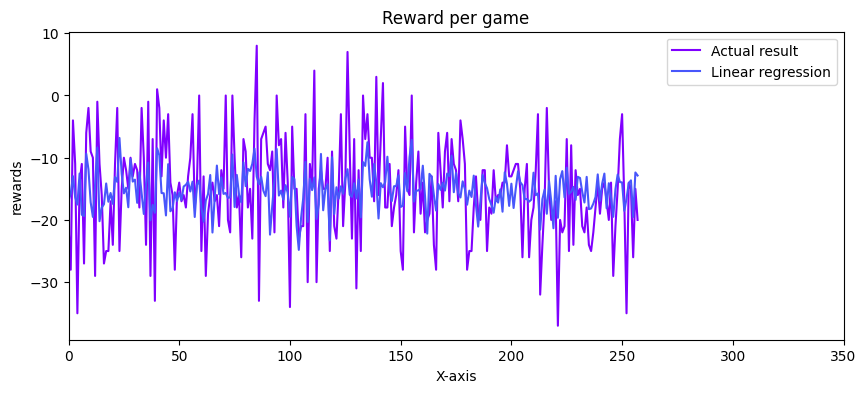

In [151]:
plt.figure(figsize=(10, 4))
for i in range(2):
    color = plt.cm.rainbow(i / len(y_result))  
    plt.plot(range(len(y_result[i])), y_result[i],  label=mark[i], color=color)
    

plt.xlim(0,350)    
plt.xlabel('X-axis')
plt.ylabel('rewards')
plt.title('Reward per game')
plt.legend(loc='upper right')
plt.show()

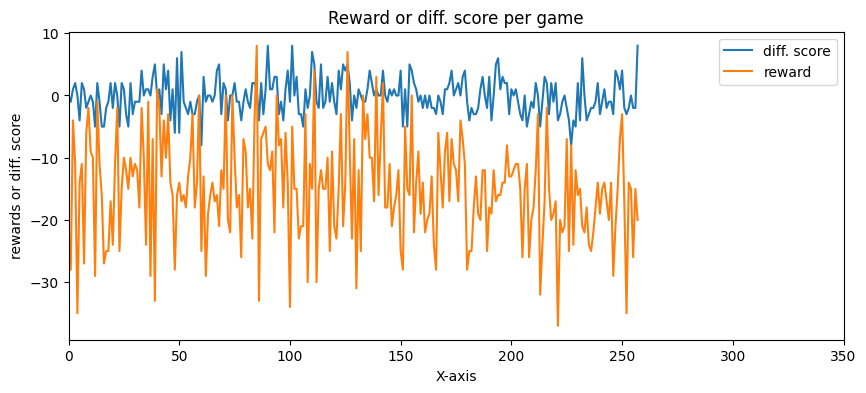

In [152]:
plt.figure(figsize=(10, 4))
plt.plot(range(len(y_test_1)), y_test_1, label="diff. score") # y_test_1 = score difference
plt.plot(range(len(y_test_3)), y_test_3, label="reward") # y_test_3 = rewaed

plt.xlim(0,350)    
plt.xlabel('X-axis')
plt.ylabel('rewards or diff. score')
plt.title('Reward or diff. score per game')
plt.legend(loc='upper right')
plt.show()

## 3.1 Linear Regression<a name = "3.1"></a>

In [153]:
LR_2 = LinearRegression()
LR_2.fit(X_train_1, y_train_1)
ypred_2 = LR_2.predict(X_test_1)
LR_mse_2 = mean_squared_error(y_test_1, ypred_2)
LR_acc_2 = LR_2.score(X_test_1,y_test_1)
print(f"Mean Squared Error: {LR_mse_2}")
print(f"Accuracy: {LR_acc_2}")

Mean Squared Error: 8.388365271572649
Accuracy: 0.0012750575289194321


## 3.2 LASSO Regression<a name = "3.2"></a>

In [154]:
lasso_regressor_2 = Lasso()

param_grid_LASSO_2 = {
    'alpha': [0.01, 0.1, 1.0, 10.0],
    'max_iter': [100, 500, 1000],
}

grid_search_LASSO_2 = GridSearchCV(estimator=lasso_regressor_2, param_grid=param_grid_LASSO_2, scoring='neg_mean_squared_error', cv=5)
grid_search_LASSO_2.fit(X_train_1, y_train_1)
best_lasso_2 = grid_search_LASSO_2.best_estimator_
y_pred_LASSO_2 = best_lasso_2.predict(X_test_1)

LASSO_mse_2 = mean_squared_error(y_test_1, y_pred_LASSO_2)
print("Best Parameters: ", grid_search_LASSO_2.best_params_)
print("Best MSE: ", LASSO_mse_2)

Best Parameters:  {'alpha': 0.01, 'max_iter': 100}
Best MSE:  8.390942379155307


## 3.3 SVR<a name = "3.3"></a>

In [155]:
svr_2 = SVR()
param_grid_SVR_2 = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
}

grid_search_SVR_2 = GridSearchCV(estimator=svr_2, param_grid=param_grid_SVR_2, scoring='neg_mean_squared_error', cv=5)
grid_search_SVR_2.fit(X_train_1, y_train_1)
best_svr_2 = grid_search_SVR_2.best_estimator_
y_pred_svr_2 = best_svr_2.predict(X_test_1)


svr_mse_2 = mean_squared_error(y_test_1, y_pred_svr_2)
print("Best Parameters: ", grid_search_SVR_2.best_params_)
print("Best MSE: ", svr_mse_2)

Best Parameters:  {'C': 0.1, 'epsilon': 0.01, 'kernel': 'linear'}
Best MSE:  8.289724660929226


## 3.4 Random Forest Regressor<a name = "3.4"></a>

In [156]:
rf_regressor_2 = RandomForestRegressor()


param_grid_rf_2 = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


grid_search_rf_2 = GridSearchCV(estimator=rf_regressor_2, param_grid=param_grid_rf_2, scoring='neg_mean_squared_error', cv=5)
grid_search_rf_2.fit(X_train_1, y_train_1)
best_rf_2 = grid_search_rf_2.best_estimator_
y_pred_rf_2 = best_rf_2.predict(X_test_1)
rf_mse_2 = mean_squared_error(y_test_1, y_pred_rf_2)
print("Best Parameters: ", grid_search_rf_2.best_params_)
print("Best MSE: ", rf_mse_2)

Best Parameters:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Best MSE:  8.3665564469679


## 3.5 KNN Regressor<a name = "3.5"></a>

In [157]:
knnr_regressor_2 = KNeighborsRegressor()

param_grid_knnr_2 = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_search_knnr_2 = GridSearchCV(estimator=knnr_regressor_2, param_grid=param_grid_knnr_2, scoring='neg_mean_squared_error', cv=5)
grid_search_knnr_2.fit(X_train_1, y_train_1)
best_knnr_2 = grid_search_knnr_2.best_estimator_
y_pred_knnr_2 = best_knnr_2.predict(X_test_1)


knnr_mse_2 = mean_squared_error(y_test_1, y_pred_knnr_2)
print("Best Parameters: ", grid_search_knnr_2.best_params_)
print("Best MSE: ", knnr_mse_2)

Best Parameters:  {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best MSE:  9.667865718431878


## 3.6 MLP Regressior (neural network)<a name = "3.6"></a>

In [158]:
mlp_regressor_2 = MLPRegressor()

param_grid_MLP_2 = {
    'hidden_layer_sizes': [(50, ), (100, ), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

grid_search_MLP_2 = GridSearchCV(estimator=mlp_regressor, param_grid=param_grid_MLP_2, scoring='neg_mean_squared_error', cv=5)
grid_search_MLP_2.fit(X_train_1, y_train_1)
best_mlp_2 = grid_search_MLP_2.best_estimator_
y_pred_MLP_2 = best_mlp_2.predict(X_test_1)

mlp_mse_2 = mean_squared_error(y_test_1, y_pred_MLP_2)
print("Best Parameters: ", grid_search_MLP_2.best_params_)
print("Best MSE: ", mlp_mse_2)

Best Parameters:  {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}
Best MSE:  8.424831254906813


## 3.7 Decision Tree Regressior<a name = "3.7"></a>

In [159]:
dt_regressor_2 = DecisionTreeRegressor()

# Define the hyperparameter grid
param_grid_DT_2 = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_DT_2 = GridSearchCV(estimator=dt_regressor_2, param_grid=param_grid_DT_2, scoring='neg_mean_squared_error', cv=5)
grid_search_DT_2.fit(X_train_1, y_train_1)
best_dt_2 = grid_search_DT_2.best_estimator_
y_pred_DT_2 = best_dt_2.predict(X_test_1)


dt_mse_2 = mean_squared_error(y_test_1, y_pred_DT_2)
print("Best Parameters: ", grid_search_DT_2.best_params_)
print("Best MSE: ", dt_mse_2)

Best Parameters:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best MSE:  10.8703713125945


## 3.8 Gradient Boosting Regressor<a name = "3.8"></a>

In [160]:
gbr_regressor_2 = GradientBoostingRegressor()

param_grid_gbr_2 = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0],
}


grid_search_gbr_2 = GridSearchCV(estimator=gbr_regressor_2, param_grid=param_grid_gbr_2, scoring='neg_mean_squared_error', cv=5)
grid_search_gbr_2.fit(X_train_1, y_train_1)
best_gbr_2 = grid_search_gbr_2.best_estimator_
y_pred_gbr_2 = best_gbr_2.predict(X_test_1)

gbr_mse_2 = mean_squared_error(y_test_1, y_pred_gbr_2)
print("Best Parameters: ", grid_search_gbr_2.best_params_)
print("Best MSE: ", gbr_mse_2)

Best Parameters:  {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 0.8}
Best MSE:  8.343151561420358


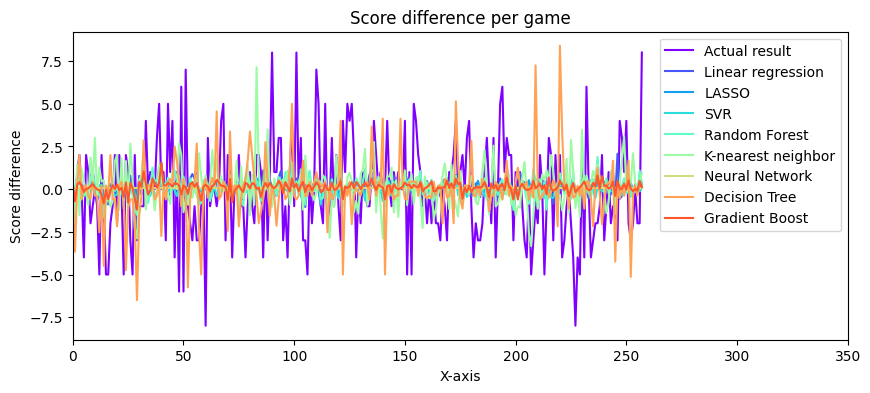

In [161]:
plt.figure(figsize=(10, 4))
y_result = [y_test_1, ypred_2, y_pred_LASSO_2, y_pred_svr_2, y_pred_rf_2, y_pred_knnr_2, y_pred_MLP_2, y_pred_DT_2, y_pred_gbr_2]
mark = ["Actual result", "Linear regression", "LASSO", "SVR", "Random Forest", "K-nearest neighbor", 
        "Neural Network", "Decision Tree", "Gradient Boost"]
for i in range(len(y_result)):
    color = plt.cm.rainbow(i / len(y_result))  
    plt.plot(range(len(y_result[i])), y_result[i],  label=mark[i], color=color)
    

plt.xlim(0,350)    
plt.xlabel('X-axis')
plt.ylabel('Score difference')
plt.title('Score difference per game')
plt.legend(loc='upper right')
plt.show()

In [162]:
# test_1 代表的是分差 (score difference)
# test_2 代表的是贏或輸 --> 只用在calssification, 這邊用不到
# test_2 代表的是reward

In [163]:
print(str(y_test_1.std()) + ": (分差結果 standard deviation)") # 分差結果 standard deviation, 
print(str(ypred_2.std()) + ": (linear regression 分差結果 standard deviation)") # linear regression standard deviation
print(y_test_1.std()/ypred_2.std())

2.9037485770761724: (分差結果 standard deviation)
0.49260759020875616: (linear regression 分差結果 standard deviation)
5.8946484682577225


In [164]:
print(str(y_test_3.std()) + ": (reward standard deviation)") 
print(str(ypred.std()) + ": (linear regression reward standard deviation)") 
print(y_test_3.std()/ypred.std())

8.277291728015701: (reward standard deviation)
3.0124622091812374: (linear regression reward standard deviation)
2.7476831751743043


In [165]:
# 1. 投手沒辦法完全主宰比賽 有其他因素會干擾 (1. 教練調度. 2.野手的守備率(失誤) 3.捕手配球(減少被安打的機率跟守備率)
# 2. 投手的每一個投球並不是完全獨立的(indpendent),他會受到體力的影響(但是體力並不會在我們的討論範圍)
# 3. 我們關注的是每一場投球的結果, 所以我們的data 會把每一場比賽這位投手的每一個投球的參數來做個別平均, 
#    所以要是投手投出一些outlier 的毀滅性結果,因為平均會normalized掉,所以在用平均的結果來predict 出得失分並部會特別好
                         

In [169]:
## MSE 兩種不同的model比較

In [181]:
MSE_result_1 = [LR_mse, LASSO_mse, svr_mse, rf_mse, knnr_mse, mlp_mse, dt_mse, gbr_mse]
MSE_result_2 = [LR_mse_2, LASSO_mse_2, svr_mse_2, rf_mse_2, knnr_mse_2, mlp_mse_2, dt_mse_2, gbr_mse_2]
column_names = mark[1:]
table_df = pd.DataFrame([MSE_result_2, MSE_result_1], columns = column_names, index = ["Score difference_MSE","reward_MSE"]).transpose()

min_result_1,  min_result_2= min(MSE_result_1), min(MSE_result_2)

def text_num_color_reward(val):
    if val == min_result_1:
        return 'color: red'  
def text_num_color_score(val):
    if val == min_result_2:
        return 'color: red'

table_df = table_df.style.applymap(text_num_color_reward, subset=["reward_MSE"])
table_df.applymap(text_num_color_score, subset=["Score difference_MSE"])

,Score difference_MSE,reward_MSE
Linear regression,8.388365,54.845142
LASSO,8.390942,56.320243
SVR,8.289725,58.538512
Random Forest,8.366556,60.175789
K-nearest neighbor,9.667866,73.982142
Neural Network,8.424831,67.632269
Decision Tree,10.870371,87.449264
Gradient Boost,8.343152,57.299927


In [171]:
table_summary = pd.DataFrame([ypred, y_test_3, y_pred_MLP_2, y_test_1], 
                         index = [["Score diff's target", "Score doff's prediction", "reward's target", "reward's prediction"]]
                        ).transpose()

table_summary.describe().iloc[[1,2],:]

,Score diff's target,Score doff's prediction,reward's target,reward's prediction
mean,-15.220592,-15.007752,5.196175e-02,-0.108527
std,3.018317,8.277292,5.873257e-09,2.903749


In [172]:
# STD比較圖

In [193]:
table_std = pd.DataFrame([[round(y_test_1.std(),2), round(ypred_2.std(),2), round(y_test_1.std()/ypred_2.std(),2)], 
                          [round(y_test_3.std(),2), round(ypred.std(),2),  round(y_test_3.std()/ypred.std(),2)]],
                        columns = ["Actual_std", "Prediction_std", "Ratio"], index = ["Score_difference", "Reward"]).transpose()

def highlight_row_func(row):
    color = 'yellow' if row.name =="Ratio" else ''  
    return ['background-color: {}'.format(color)] * len(row)


print("Using 'Reward' is a preferable choice compared to utilizing 'Score Difference' as a target.")
table_std.style.apply(highlight_row_func, axis=1)

Using 'Reward' is a preferable choice compared to utilizing 'Score Difference' as a target.


,Score_difference,Reward
Actual_std,2.900000,8.280000
Prediction_std,0.490000,3.010000
Ratio,5.890000,2.750000


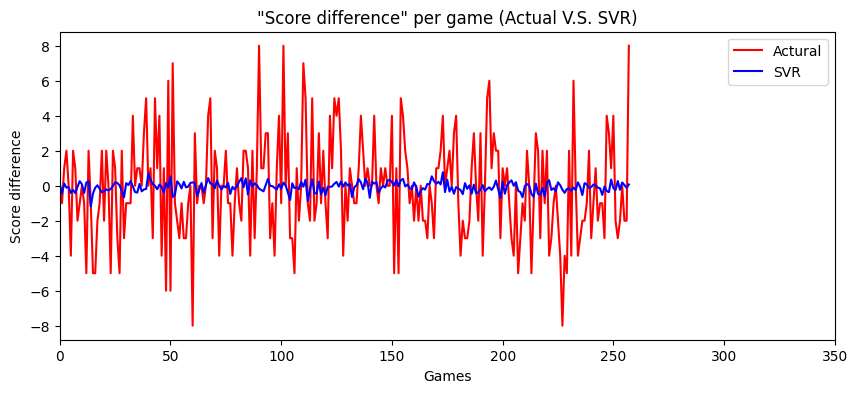

In [199]:
plt.figure(figsize=(10, 4))
plt.plot(range(len(y_test_1)), y_test_1,  label="Actural", color="red")
plt.plot(range(len(y_test_1)), y_pred_svr_2,  label="SVR", color="blue")
         
plt.xlim(0,350)    
plt.xlabel('Games')
plt.ylabel('Score difference')
plt.title('"Score difference" per game (Actual V.S. SVR)')
plt.legend(loc='upper right')
plt.show()

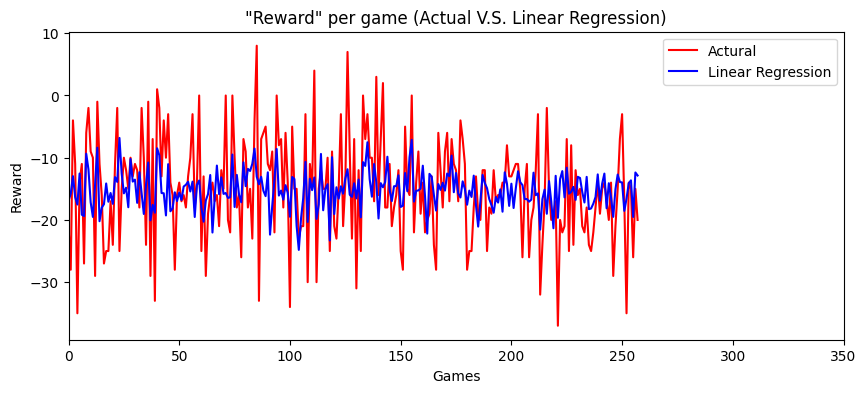

In [198]:
plt.figure(figsize=(10, 4))
plt.plot(range(len(y_test_3)), y_test_3,  label="Actural", color="red")
plt.plot(range(len(y_test_3)), ypred,  label="Linear Regression", color="blue")
         
plt.xlim(0,350)    
plt.xlabel('Games')
plt.ylabel('Reward')
plt.title('"Reward" per game (Actual V.S. Linear Regression)')
plt.legend(loc='upper right')
plt.show()